In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

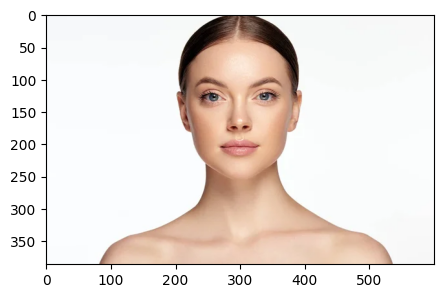

In [5]:
face = cv2.imread("../images/face.jpg")
face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5, 5))
plt.imshow(face)
plt.show()

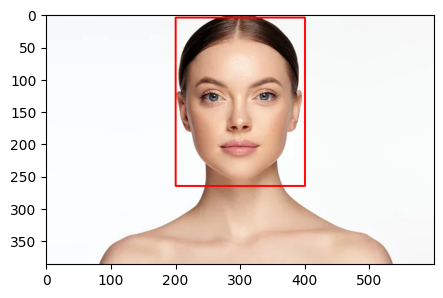

In [11]:
detector = cv2.CascadeClassifier("../data/haarcascade_frontalface_default.xml")
results = detector.detectMultiScale(face, 1.3, 5)
face_copy = np.copy(face)
for (x, y, w, h) in results:
    cv2.rectangle(face_copy, (x, y-40), (x+w, y+h+20), (255, 0, 0), 2)

plt.figure(figsize=(5, 5))
plt.imshow(face_copy)
plt.show()



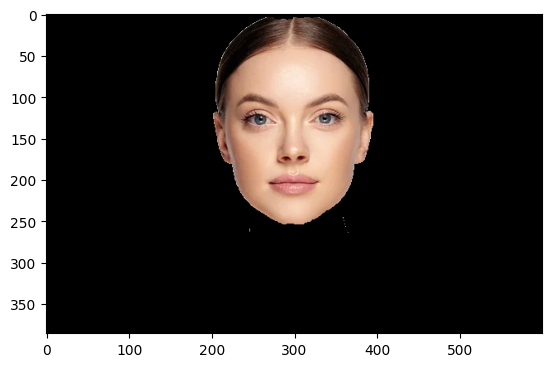

Total time taken for segmentation: 0.93 seconds


In [14]:
# segment out the face using grabcut
st = time.time()
bgModel = np.zeros((1, 65), np.float64)
fgModel = np.zeros((1, 65), np.float64)

mask = np.zeros(face.shape[:2], np.uint8)

rect = (results[0][0], results[0][1]-40, results[0][2], results[0][3]+60)
face_copy = np.copy(face)
cv2.grabCut(face_copy, mask, rect, bgModel, fgModel, 5, cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')
face_copy = face_copy*mask2[:, :, np.newaxis]

plt.imshow(face_copy)
plt.show()

et = time.time()
print(f"Total time taken for segmentation: {et-st:.2f} seconds")

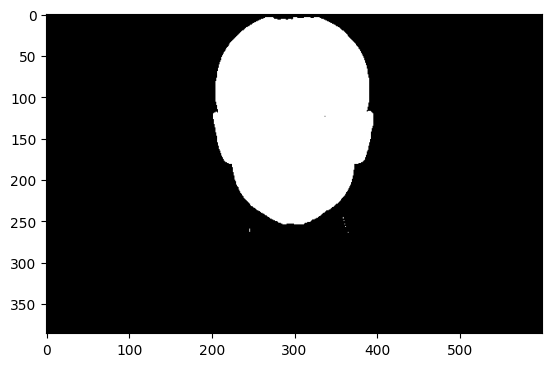

In [16]:
# display face mask
plt.imshow(mask2, cmap='gray')
plt.show()

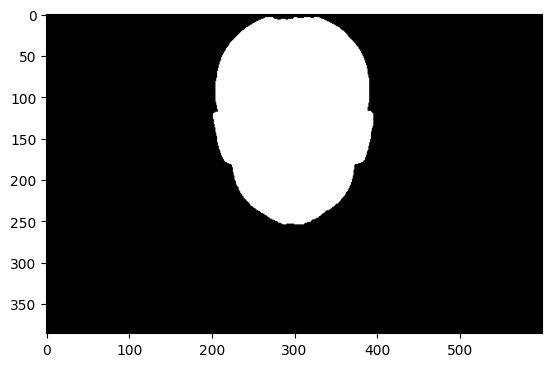

In [17]:
# smoothen the mask with a gaussian filter
mask2 = cv2.GaussianBlur(mask2, (5, 5), 0)
plt.imshow(mask2, cmap='gray')
plt.show()